# 🥣 01 - Ingestion des données OpenFoodFacts
Ce notebook a pour objectif de lire les données OpenFoodFacts brutes au format `.csv.gz`, de les analyser rapidement et de les convertir en format `Parquet` pour les étapes suivantes du pipeline.

In [1]:
# ⚙️ Installer pyspark si besoin (ex: sur Google Colab)
try:
    import pyspark
except ImportError:
    %pip install pyspark

In [2]:
# 📦 Imports principaux
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os

In [3]:
# 🚀 Création de la SparkSession
spark = SparkSession.builder \
    .appName("OpenFoodFacts Ingestion") \
    .getOrCreate()

In [4]:
# 📥 Lecture du fichier .csv.gz (format TSV)
input_path = "../data/en.openfoodfacts.org.products.csv.gz"

df_raw = spark.read.option("header", True) \
                   .option("sep", "\t") \
                   .option("inferSchema", True) \
                   .csv(input_path)

df_raw.cache()
df_raw.printSchema()


root
 |-- code: double (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: integer (nullable = true)
 |-- created_datetime: timestamp (nullable = true)
 |-- last_modified_t: integer (nullable = true)
 |-- last_modified_datetime: timestamp (nullable = true)
 |-- last_modified_by: string (nullable = true)
 |-- last_updated_t: integer (nullable = true)
 |-- last_updated_datetime: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- brands_en: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- catego

In [5]:
# 🔢 Dimensions du DataFrame
n_rows = df_raw.count()
n_cols = len(df_raw.columns)
print(f"Nombre de lignes: {n_rows:,}")
print(f"Nombre de colonnes: {n_cols}")

Nombre de lignes: 3,904,751
Nombre de colonnes: 209


In [6]:
# 📋 Affichage des noms de colonnes
print("\n🧾 Liste des colonnes :")
for i, col_name in enumerate(df_raw.columns, start=1):
    print(f"{i:02d}. {col_name}")



🧾 Liste des colonnes :
01. code
02. url
03. creator
04. created_t
05. created_datetime
06. last_modified_t
07. last_modified_datetime
08. last_modified_by
09. last_updated_t
10. last_updated_datetime
11. product_name
12. abbreviated_product_name
13. generic_name
14. quantity
15. packaging
16. packaging_tags
17. packaging_en
18. packaging_text
19. brands
20. brands_tags
21. brands_en
22. categories
23. categories_tags
24. categories_en
25. origins
26. origins_tags
27. origins_en
28. manufacturing_places
29. manufacturing_places_tags
30. labels
31. labels_tags
32. labels_en
33. emb_codes
34. emb_codes_tags
35. first_packaging_code_geo
36. cities
37. cities_tags
38. purchase_places
39. stores
40. countries
41. countries_tags
42. countries_en
43. ingredients_text
44. ingredients_tags
45. ingredients_analysis_tags
46. allergens
47. allergens_en
48. traces
49. traces_tags
50. traces_en
51. serving_size
52. serving_quantity
53. no_nutrition_data
54. additives_n
55. additives
56. additives_ta

In [7]:
# 💾 Sauvegarde des données ingérées au format CSV
import os
import time

# ⏱️ Mesure des performances d'écriture

print("\n📝 Phase 1: Mesure des performances d'écriture")
print("-" * 50)

# ✍️ Mesure du temps d'écriture au format CSV
print("⏳ Mesure du temps d'écriture CSV pour comparaison...")
start_time = time.time()

# Chemin absolu vers le dossier de sortie CSV
output_dir = os.path.abspath(os.path.join(os.getcwd(), "../data/step1_raw_csv"))
os.makedirs(output_dir, exist_ok=True)

# Écriture au format CSV (avec header)
df_raw.write \
.option("header", "true") \
.option("sep", ";")\
.mode("overwrite") \
.csv(output_dir)

csv_write_time = time.time() - start_time
print(f"✅ Écriture CSV terminée en {csv_write_time:.2f} secondes")
# Affichage du chemin de sortie
print(f"✅ Ingestion CSV terminée dans : {output_dir}")



📝 Phase 1: Mesure des performances d'écriture
--------------------------------------------------
⏳ Mesure du temps d'écriture CSV pour comparaison...
✅ Écriture CSV terminée en 401.76 secondes
✅ Ingestion CSV terminée dans : /home/jovyan/work/data/step1_raw_csv


In [8]:
# 💾 Sauvegarde au format Parquet
print("🚀 Début de la comparaison CSV vs Parquet")
print("=" * 60)

# Utilisation du chemin CSV existant et création du chemin Parquet

parquet_output_dir = os.path.abspath(os.path.join(os.getcwd(), "../data/step1_raw_parquet"))

# Création du dossier Parquet (CSV déjà créé)
os.makedirs(parquet_output_dir, exist_ok=True)

🚀 Début de la comparaison CSV vs Parquet


In [9]:
# 📊 Comparatif des performances entre CSV et Parquet

# ✍️ Écriture Parquet
print("⏳ Écriture au format Parquet...")
start_time = time.time()

df_raw.write \
    .mode("overwrite") \
    .parquet(parquet_output_dir)

parquet_write_time = time.time() - start_time
print(f"✅ Écriture Parquet terminée en {parquet_write_time:.2f} secondes")

⏳ Écriture au format Parquet...
✅ Écriture Parquet terminée en 169.48 secondes


In [10]:
# 📖 Mesure des performances de lecture

print("\n📖 Phase 2: Mesure des performances de lecture")
print("-" * 50)

# 📚 Lecture CSV
print("⏳ Lecture du format CSV...")
start_time = time.time()

df_csv = spark.read \
    .option("header", "true") \
    .option("sep", ";") \
    .option("inferSchema", "true") \
    .csv(output_dir)

# Action pour déclencher la lecture
csv_count = df_csv.count()
csv_read_time = time.time() - start_time
print(f"✅ Lecture CSV terminée en {csv_read_time:.2f} secondes ({csv_count:,} lignes)")

# 📚 Lecture Parquet
print("⏳ Lecture du format Parquet...")
start_time = time.time()

df_parquet = spark.read.parquet(parquet_output_dir)

# Action pour déclencher la lecture
parquet_count = df_parquet.count()
parquet_read_time = time.time() - start_time
print(f"✅ Lecture Parquet terminée en {parquet_read_time:.2f} secondes ({parquet_count:,} lignes)")


📖 Phase 2: Mesure des performances de lecture
--------------------------------------------------
⏳ Lecture du format CSV...
✅ Lecture CSV terminée en 50.50 secondes (3,904,751 lignes)
⏳ Lecture du format Parquet...
✅ Lecture Parquet terminée en 0.67 secondes (3,904,751 lignes)


In [11]:
# 📏 Mesure de la taille des fichiers

print("\n📏 PHASE 3: Comparaison de la taille des fichiers")
print("-" * 50)

def get_directory_size(path):
    """Calcule la taille totale d'un dossier en octets"""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            if os.path.exists(filepath):
                total_size += os.path.getsize(filepath)
    return total_size

def format_size(size_bytes):
    """Formate la taille en unités lisibles"""
    if size_bytes == 0:
        return "0 B"
    
    units = ['B', 'KB', 'MB', 'GB', 'TB']
    i = 0
    while size_bytes >= 1024 and i < len(units) - 1:
        size_bytes /= 1024
        i += 1
    
    return f"{size_bytes:.2f} {units[i]}"

# Calcul des tailles
csv_size = get_directory_size(output_dir)
parquet_size = get_directory_size(parquet_output_dir)

print(f"📁 Taille CSV: {format_size(csv_size)}")
print(f"📁 Taille Parquet: {format_size(parquet_size)}")

# Calcul du ratio de compression
if csv_size > 0:
    compression_ratio = (csv_size - parquet_size) / csv_size * 100
    print(f"📊 Compression: {compression_ratio:.1f}% (Parquet vs CSV)")
else:
    compression_ratio = 0
    print("⚠️ Impossible de calculer le ratio de compression car la taille du CSV est nulle.")



📏 PHASE 3: Comparaison de la taille des fichiers
--------------------------------------------------
📁 Taille CSV: 10.65 GB
📁 Taille Parquet: 1.32 GB
📊 Compression: 87.6% (Parquet vs CSV)


In [12]:
# 📊 Résumé des performances

print("\n" + "=" * 60)
print("📊 Résumé des performances des formats CSV vs Parquet")
print("=" * 60)

print(f"""
🔸 ÉCRITURE:
   • CSV:     {csv_write_time:.2f}s
   • Parquet: {parquet_write_time:.2f}s
   • Gain:    {((csv_write_time - parquet_write_time) / csv_write_time * 100):+.1f}%

🔸 LECTURE:
   • CSV:     {csv_read_time:.2f}s
   • Parquet: {parquet_read_time:.2f}s
   • Gain:    {((csv_read_time - parquet_read_time) / csv_read_time * 100):+.1f}%

🔸 TAILLE:
   • CSV:     {format_size(csv_size)}
   • Parquet: {format_size(parquet_size)}
   • Gain:    {compression_ratio:.1f}%

🔸 PERFORMANCE GLOBALE:
   • Temps total CSV:     {csv_write_time + csv_read_time:.2f}s
   • Temps total Parquet: {parquet_write_time + parquet_read_time:.2f}s
   • Gain total:          {((csv_write_time + csv_read_time - parquet_write_time - parquet_read_time) / (csv_write_time + csv_read_time) * 100):+.1f}%
""")


📊 Résumé des performances des formats CSV vs Parquet

🔸 ÉCRITURE:
   • CSV:     401.76s
   • Parquet: 169.48s
   • Gain:    +57.8%

🔸 LECTURE:
   • CSV:     50.50s
   • Parquet: 0.67s
   • Gain:    +98.7%

🔸 TAILLE:
   • CSV:     10.65 GB
   • Parquet: 1.32 GB
   • Gain:    87.6%

🔸 PERFORMANCE GLOBALE:
   • Temps total CSV:     452.26s
   • Temps total Parquet: 170.15s
   • Gain total:          +62.4%


In [13]:
# 📝 Recommandations et conclusion

print("\n" + "=" * 60)
print("📝 Recommandations")
print("=" * 60)

recommendations = []

if parquet_write_time < csv_write_time:
    recommendations.append("✅ Parquet est plus rapide en écriture")
else:
    recommendations.append("⚠️ CSV est plus rapide en écriture")

if parquet_read_time < csv_read_time:
    recommendations.append("✅ Parquet est plus rapide en lecture")
else:
    recommendations.append("⚠️ CSV est plus rapide en lecture")

if parquet_size < csv_size:
    recommendations.append("✅ Parquet occupe moins d'espace disque")
else:
    recommendations.append("⚠️ CSV occupe moins d'espace disque")

# if parquet_query_time < csv_query_time:
    # recommendations.append("✅ Parquet est plus performant pour les requêtes")
# else:
    #recommendations.append("⚠️ CSV est plus performant pour les requêtes")

for rec in recommendations:
    print(f"  {rec}")

print(f"\n🎯 Conclusion: {'Parquet' if len([r for r in recommendations if 'Parquet' in r and '✅' in r]) >= 2 else 'CSV'} semble être le meilleur choix pour ce dataset.")


📝 Recommandations
  ✅ Parquet est plus rapide en écriture
  ✅ Parquet est plus rapide en lecture
  ✅ Parquet occupe moins d'espace disque

🎯 Conclusion: Parquet semble être le meilleur choix pour ce dataset.



Génération des visualisations


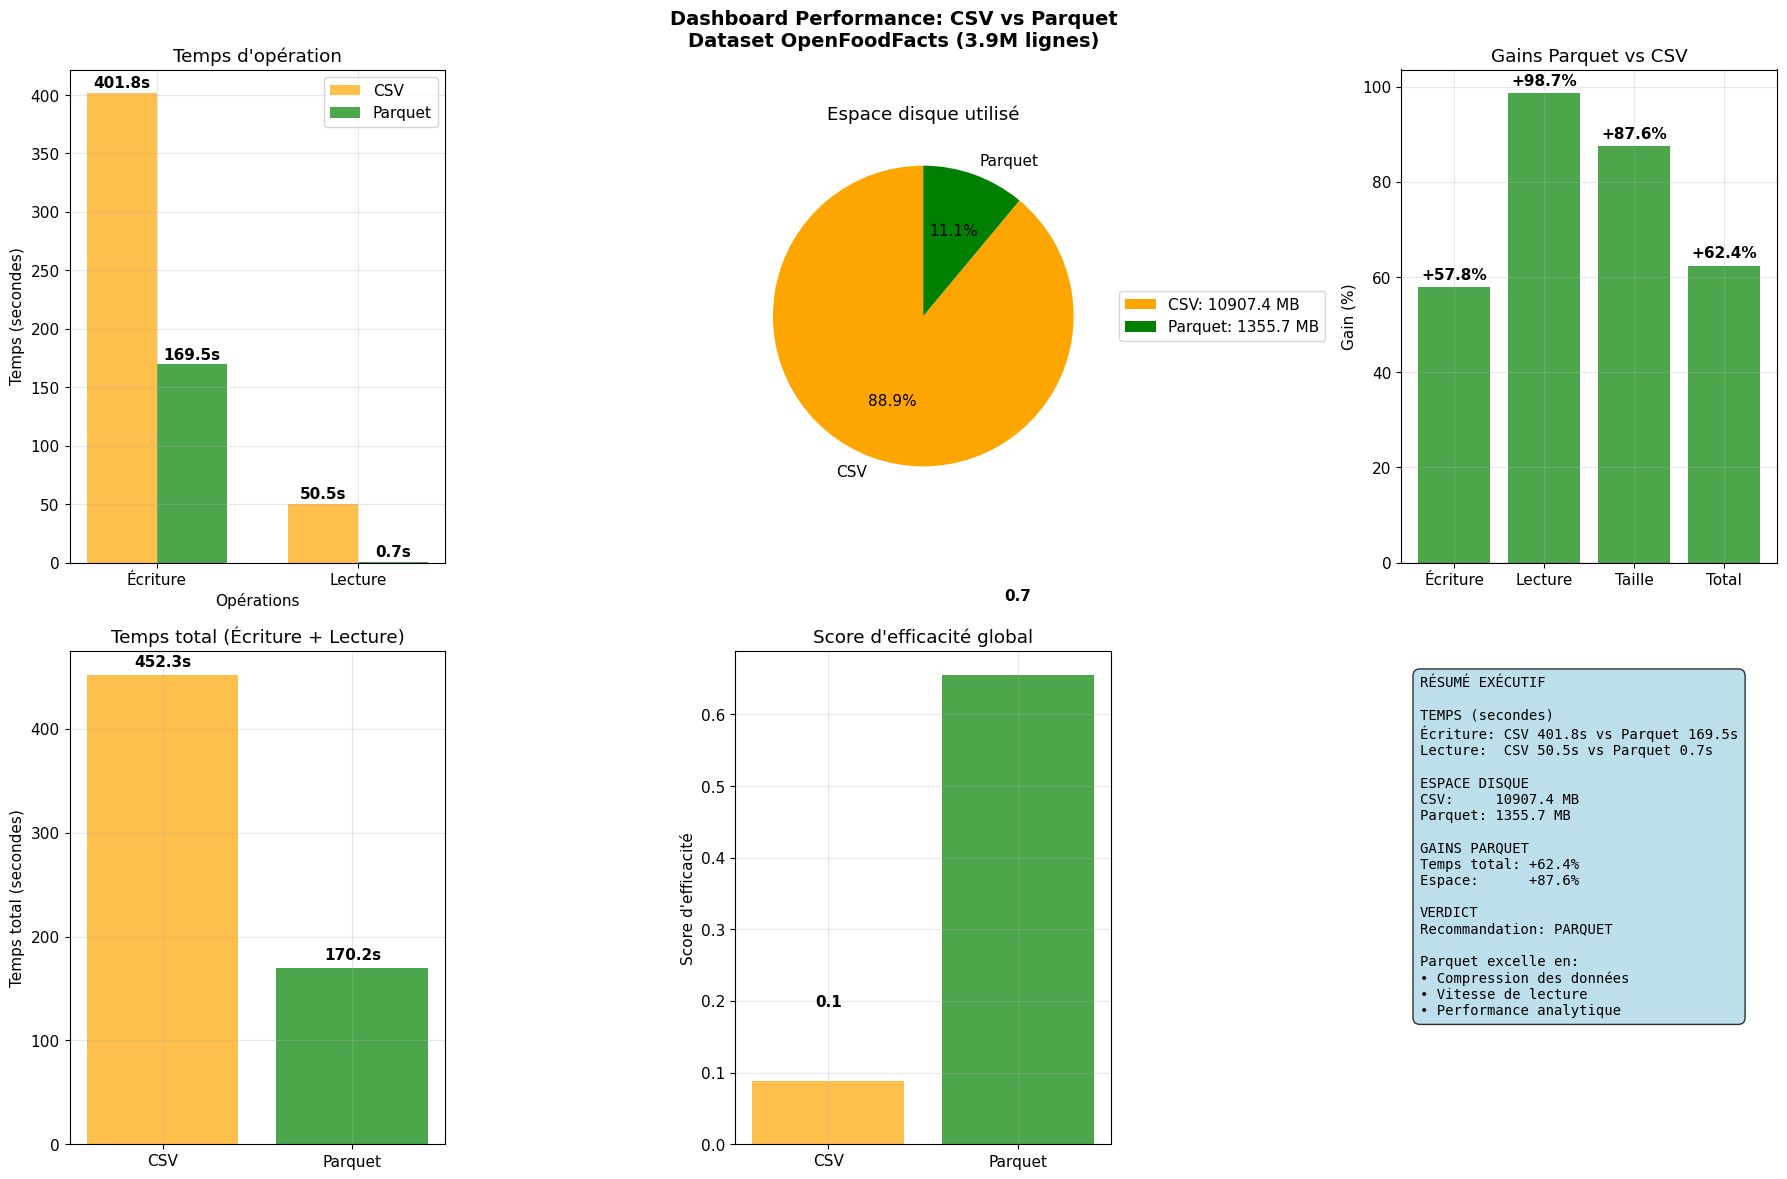

Visualisations générées avec succès!


In [14]:
# 📊 Visualisations des performances avec matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Configuration matplotlib pour de beaux graphiques
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11

print("\n" + "=" * 60)
print("Génération des visualisations")
print("=" * 60)

def format_size_mb(size_bytes):
    """Formate la taille en MB"""
    return f'{size_bytes / (1024*1024):.1f} MB'

def create_performance_dashboard():
    """Crée un dashboard complet des performances"""

    # Création de la figure avec 6 sous-graphiques
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))

    # === 1. Temps d'opération (barres) ===
    operations = ['Écriture', 'Lecture']
    csv_times = [csv_write_time, csv_read_time]
    parquet_times = [parquet_write_time, parquet_read_time]

    x = np.arange(len(operations))
    width = 0.35

    bars1 = ax1.bar(x - width/2, csv_times, width, label='CSV', color='orange', alpha=0.7)
    bars2 = ax1.bar(x + width/2, parquet_times, width, label='Parquet', color='green', alpha=0.7)

    ax1.set_xlabel('Opérations')
    ax1.set_ylabel('Temps (secondes)')
    ax1.set_title('Temps d\'opération')
    ax1.set_xticks(x)
    ax1.set_xticklabels(operations)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

    # === 2. Répartition de l'espace disque (secteurs) ===
    sizes = [csv_size, parquet_size]
    labels = ['CSV', 'Parquet']
    colors = ['orange', 'green']

    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors,
                                       autopct='%1.1f%%', startangle=90)
    ax2.set_title('Espace disque utilisé')

    legend_labels = [f'{label}: {format_size_mb(size)}' for label, size in zip(labels, sizes)]
    ax2.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # === 3. Gains de performance ===
    write_gain = ((csv_write_time - parquet_write_time) / csv_write_time * 100)
    read_gain = ((csv_read_time - parquet_read_time) / csv_read_time * 100)
    size_gain = ((csv_size - parquet_size) / csv_size * 100)
    total_gain = (((csv_write_time + csv_read_time) - (parquet_write_time + parquet_read_time)) /
                  (csv_write_time + csv_read_time) * 100)

    metrics = ['Écriture', 'Lecture', 'Taille', 'Total']
    gains = [write_gain, read_gain, size_gain, total_gain]
    colors_gain = ['green' if g > 0 else 'red' for g in gains]

    bars = ax3.bar(metrics, gains, color=colors_gain, alpha=0.7)
    ax3.set_ylabel('Gain (%)')
    ax3.set_title('Gains Parquet vs CSV')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax3.grid(True, alpha=0.3)

    for bar, gain in zip(bars, gains):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2.,
                 height + (1 if height > 0 else -2),
                 f'{gain:+.1f}%', ha='center',
                 va='bottom' if height > 0 else 'top',
                 fontweight='bold')

    # === 4. Comparaison temps total ===
    total_times = [csv_write_time + csv_read_time, parquet_write_time + parquet_read_time]
    formats = ['CSV', 'Parquet']
    colors_total = ['orange', 'green']

    bars = ax4.bar(formats, total_times, color=colors_total, alpha=0.7)
    ax4.set_ylabel('Temps total (secondes)')
    ax4.set_title('Temps total (Écriture + Lecture)')
    ax4.grid(True, alpha=0.3)

    for bar, time in zip(bars, total_times):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

    # === 5. Efficacité relative ===
    csv_score = 1000 / (csv_write_time + csv_read_time + csv_size/(1024**2))
    parquet_score = 1000 / (parquet_write_time + parquet_read_time + parquet_size/(1024**2))

    scores = [csv_score, parquet_score]

    bars = ax5.bar(formats, scores, color=colors_total, alpha=0.7)
    ax5.set_ylabel('Score d\'efficacité')
    ax5.set_title('Score d\'efficacité global')
    ax5.grid(True, alpha=0.3)

    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

    # === 6. Résumé textuel ===
    ax6.axis('off')

    summary = f"""RÉSUMÉ EXÉCUTIF
    
TEMPS (secondes)
Écriture: CSV {csv_write_time:.1f}s vs Parquet {parquet_write_time:.1f}s
Lecture:  CSV {csv_read_time:.1f}s vs Parquet {parquet_read_time:.1f}s

ESPACE DISQUE
CSV:     {format_size_mb(csv_size)}
Parquet: {format_size_mb(parquet_size)}

GAINS PARQUET
Temps total: {total_gain:+.1f}%
Espace:      {size_gain:+.1f}%

VERDICT
Recommandation: {'PARQUET' if total_gain > 0 and size_gain > 0 else 'CSV'}

Parquet excelle en:
• Compression des données
• Vitesse de lecture
• Performance analytique"""

    ax6.text(0.05, 0.95, summary, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.suptitle('Dashboard Performance: CSV vs Parquet\nDataset OpenFoodFacts (3.9M lignes)',
                 fontsize=14, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

# Génération du dashboard
create_performance_dashboard()

print("Visualisations générées avec succès!")